<a href="https://colab.research.google.com/github/hmyrcmn/KUL/blob/main/my_dog_cat_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Kaggle API anahtarını yükle
uploaded = files.upload()

# Yüklenen kaggle.json dosyasını Colab dizinine taşı
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d erkamk/cat-and-dog-images-dataset
import zipfile
import os

# Zip dosyasını çıkart
with zipfile.ZipFile('/content/cat-and-dog-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# İçerideki dosyaları göster
os.listdir('/content/')


Saving kaggle.json to kaggle.json
 99% 127M/128M [00:06<00:00, 23.2MB/s]
100% 128M/128M [00:06<00:00, 20.2MB/s]


['.config',
 'y.pickle',
 'Dog and Cat .png',
 'y.npy',
 'cat-and-dog-images-dataset.zip',
 'X_gray.pickle',
 'x_gray.npy',
 'sample_data']

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Veri setini yükleyip işleme fonksiyonları
def load_data():
    # "cat" ve "dog" klasörlerinden veriyi yükle
    cat_folder = "/content/Dog and Cat .png/Cat"
    dog_folder = "/content/Dog and Cat .png/Dog"

    cat_images = [cv2.imread(os.path.join(cat_folder, file), cv2.IMREAD_GRAYSCALE) for file in os.listdir(cat_folder)]
    dog_images = [cv2.imread(os.path.join(dog_folder, file), cv2.IMREAD_GRAYSCALE) for file in os.listdir(dog_folder)]

    # Etiketleri oluştur
    cat_labels = np.zeros(len(cat_images))
    dog_labels = np.ones(len(dog_images))

    # Veriyi birleştir
    X_data = np.array(cat_images + dog_images)
    y_data = np.concatenate([cat_labels, dog_labels])

    return X_data, y_data

# Veriyi yükle
X_data, y_data = load_data()
print("X_data",X_data.shape)
print("y_data",y_data.shape)




X_data (1000,)
y_data (1000,)


<ipython-input-2-d94f1af976f8>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_data = np.array(cat_images + dog_images)


In [ ]:
X_data[0]

array([[184, 185, 186, ..., 164, 158, 155],
       [186, 186, 187, ..., 167, 161, 158],
       [188, 189, 189, ..., 171, 165, 163],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

## uyarlama

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import os, cv2, re, random
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split



image_dir = Path("/content/Dog and Cat .png")


filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)



image_df

,Filepath,Label
0,/content/Dog and Cat .png/Cat/372.png,Cat
1,/content/Dog and Cat .png/Cat/16.png,Cat
2,/content/Dog and Cat .png/Cat/t81.png,Cat
3,/content/Dog and Cat .png/Cat/303.png,Cat
4,/content/Dog and Cat .png/Cat/128.png,Cat
...,...,...
994,/content/Dog and Cat .png/Dog/d189.png,Dog
995,/content/Dog and Cat .png/Dog/d371.png,Dog
996,/content/Dog and Cat .png/Dog/d169.png,Dog
997,/content/Dog and Cat .png/Dog/d39.png,Dog


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Veri setini yükleme ve bölme
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Eğitim veri seti
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

# Doğrulama veri seti
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

# Test veri seti
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Eğitim veri seti
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# Doğrulama veri seti
val_images = val_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test veri seti
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


print("train_df:",sample_images.shape)
print("test_df:",sample_labels.shape)


Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
train_df: (699, 2)
test_df: (300, 2)


sample_images: (32, 224, 224, 1)
sample_images: [[[0.54509807]
  [0.54509807]
  [0.5465856 ]
  ...
  [0.89501035]
  [0.89501035]
  [0.89501035]]

 [[0.54663944]
  [0.54509807]
  [0.54702395]
  ...
  [0.8910888 ]
  [0.8910888 ]
  [0.8910888 ]]

 [[0.54709375]
  [0.54509807]
  [0.5455365 ]
  ...
  [0.893225  ]
  [0.893225  ]
  [0.893225  ]]

 ...

 [[0.8998954 ]
  [0.9078083 ]
  [0.90210027]
  ...
  [0.12941177]
  [0.12941177]
  [0.12941177]]

 [[0.8998954 ]
  [0.9078083 ]
  [0.90210027]
  ...
  [0.12941177]
  [0.12941177]
  [0.12941177]]

 [[0.8998954 ]
  [0.9078083 ]
  [0.90210027]
  ...
  [0.12941177]
  [0.12941177]
  [0.12941177]]]


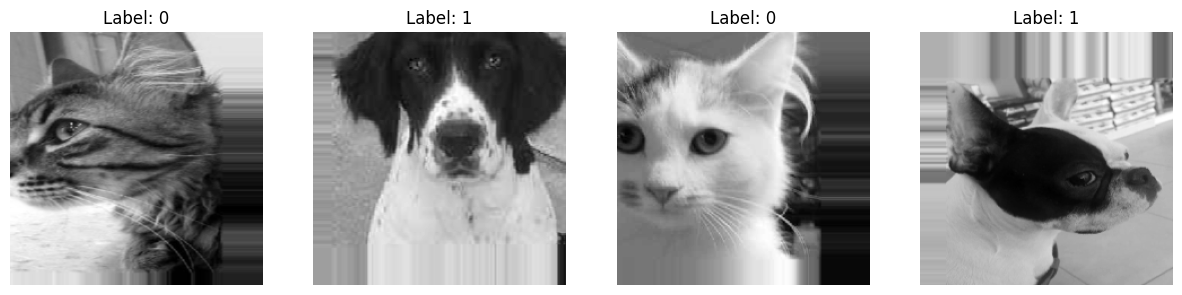

In [ ]:
import matplotlib.pyplot as plt

# Eğitim verilerinden bir örnek alalım
sample_images, sample_labels = next(train_images)

print("sample_images:",sample_images.shape)
print("sample_images:",sample_images[0])

# Bir satır ve dört sütuna sahip bir alt grafik düzeni oluşturun
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# İlk dört örneği görselleştirin
for i in range(4):
    axes[i].imshow(sample_images[i].reshape(224, 224), cmap='gray')  # Gri tonlamalı olduğu için cmap='gray'
    axes[i].set_title(f"Label: {int(sample_labels[i])}")
    axes[i].axis('off')

plt.show()


In [ ]:
print("train_df",train_df)

train_df                                    Filepath Label
730   /content/Dog and Cat .png/Dog/g40.png   Dog
669  /content/Dog and Cat .png/Dog/d163.png   Dog
639  /content/Dog and Cat .png/Dog/d294.png   Dog
803  /content/Dog and Cat .png/Dog/d367.png   Dog
736  /content/Dog and Cat .png/Dog/d314.png   Dog
..                                      ...   ...
767   /content/Dog and Cat .png/Dog/g95.png   Dog
72    /content/Dog and Cat .png/Cat/373.png   Cat
908  /content/Dog and Cat .png/Dog/d151.png   Dog
235   /content/Dog and Cat .png/Cat/154.png   Cat
37    /content/Dog and Cat .png/Cat/146.png   Cat

[699 rows x 2 columns]
